In [1]:
!pip install -q "monai[transformers, pandas]"
!pip install transformers
!pip install -q scikit-learn==1.0.2
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 86.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 70.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.3 requires scikit-lea

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from sklearn.metrics import roc_auc_score
from monai.optimizers.lr_scheduler import WarmupCosineSchedule
# from monai.networks.nets import Transchex
from monai.config import print_config
from monai.utils import set_determinism
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
torch.backends.cudnn.benchmark = True
print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.13.1
Pillow version: 11.0.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#inst

In [3]:
datadir = "./monai_data"
if not os.path.exists(datadir):
    os.makedirs(datadir)

In [4]:
set_determinism(seed=0)

In [5]:
import timm

# # List all available models
# model_names = timm.list_models()
# print(model_names)


In [6]:
from __future__ import annotations

import math
from collections.abc import Sequence

import torch
from torch import nn

from monai.config.type_definitions import PathLike
from monai.utils import optional_import

transformers = optional_import("transformers")
load_tf_weights_in_roberta = optional_import("transformers", name="load_tf_weights_in_roberta")[0]
cached_file = optional_import("transformers.utils", name="cached_file")[0]
RobertaEmbeddings = optional_import("transformers.models.roberta.modeling_roberta", name="RobertaEmbeddings")[0]
RobertaLayer = optional_import("transformers.models.roberta.modeling_roberta", name="RobertaLayer")[0]

__all__ = ["RobertaPreTrainedModel", "RobertaAttention", "RobertaOutput", "RobertaMixedLayer", "Pooler", "MultiModal", "Transchex"]




class RobertaPreTrainedModel(nn.Module):
    """Module to load RoBERTa pre-trained weights."""

    def __init__(self, *inputs, **kwargs) -> None:
        super().__init__()

    def init_roberta_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, torch.nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    @classmethod
    def from_pretrained(
        cls,
        num_language_layers,
        num_vision_layers,
        num_mixed_layers,
        roberta_config,
        state_dict=None,
        cache_dir=None,
        from_tf=False,
        path_or_repo_id="roberta-base",
        filename="pytorch_model.bin",
        *inputs,
        **kwargs,
    ):
        weights_path = cached_file(path_or_repo_id, filename, cache_dir=cache_dir)
        model = cls(num_language_layers, num_vision_layers, num_mixed_layers, roberta_config, *inputs, **kwargs)
        if state_dict is None and not from_tf:
            state_dict = torch.load(weights_path, map_location="cpu" if not torch.cuda.is_available() else None)
        if from_tf:
            return load_tf_weights_in_roberta(model, weights_path)
        old_keys = []
        new_keys = []
        for key in state_dict.keys():
            new_key = None
            if "gamma" in key:
                new_key = key.replace("gamma", "weight")
            if "beta" in key:
                new_key = key.replace("beta", "bias")
            if new_key:
                old_keys.append(key)
                new_keys.append(new_key)
        for old_key, new_key in zip(old_keys, new_keys):
            state_dict[new_key] = state_dict.pop(old_key)
        missing_keys: list = []
        unexpected_keys: list = []
        error_msgs: list = []
        metadata = getattr(state_dict, "_metadata", None)
        state_dict = state_dict.copy()
        if metadata is not None:
            state_dict._metadata = metadata

        def load(module, prefix=""):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(
                state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs
            )
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + ".")

        start_prefix = ""
        if not hasattr(model, "roberta") and any(s.startswith("roberta.") for s in state_dict.keys()):
            start_prefix = "roberta."
        load(model, prefix=start_prefix)
        return model


class RobertaAttention(nn.Module):
    """RoBERTa attention layer."""

    def __init__(self, config) -> None:
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, context):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(context)
        mixed_value_layer = self.value(context)
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.dropout(nn.Softmax(dim=-1)(attention_scores))
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer


class RobertaOutput(nn.Module):
    """RoBERTa output layer."""

    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = torch.nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class RobertaMixedLayer(nn.Module):
    """RoBERTa cross attention layer."""

    def __init__(self, config) -> None:
        super().__init__()
        self.att_x = RobertaAttention(config)
        self.output_x = RobertaOutput(config)
        self.att_y = RobertaAttention(config)
        self.output_y = RobertaOutput(config)

    def forward(self, x, y):
        output_x = self.att_x(x, y)
        output_y = self.att_y(y, x)
        return self.output_x(output_x, x), self.output_y(output_y, y)


class Pooler(nn.Module):
    """BERT pooler layer.
    Based on: BERT (pytorch-transformer)
    https://github.com/huggingface/transformers
    """

    def __init__(self, hidden_size) -> None:
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        first_token_tensor = hidden_states
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class MultiModal(RobertaPreTrainedModel):
    """
    Multimodal Transformers From Pretrained RoBERTa Weights"
    """

    def __init__(
        self, num_language_layers: int, num_vision_layers: int, num_mixed_layers: int, roberta_config: dict
    ) -> None:
        """
        Args:
            num_language_layers: number of language transformer layers.
            num_vision_layers: number of vision transformer layers.
            roberta_config: configuration for RoBERTa language transformer encoder.
        """
        super().__init__()
        self.config = type("obj", (object,), roberta_config)
        self.embeddings = RobertaEmbeddings(self.config)
        self.language_encoder = nn.ModuleList([RobertaLayer(self.config) for _ in range(num_language_layers)])
        # NFNet (NON-PRETRAINED)
        self.vision_encoder = timm.create_model("nfnet_f1", pretrained=False, features_only=True)
        # Projection layer to match feature dimension with transformer input (B, N, D)
        self.vision_proj = nn.Linear(3072, 768)  # Fix input dimension
        self.mixed_encoder = nn.ModuleList([RobertaMixedLayer(self.config) for _ in range(num_mixed_layers)])
        self.apply(self.init_roberta_weights)

    def forward(self, input_ids, token_type_ids=None, vision_feats=None, attention_mask=None):
        language_features = self.embeddings(input_ids, token_type_ids)
        vision_feats = self.vision_encoder(vision_feats)[-1]  # Extract the last feature map
        # Flatten and project vision features
        batch_size, channels, height, width = vision_feats.shape
        vision_feats = vision_feats.flatten(2).transpose(1, 2)  # (B, H*W, C)
        vision_feats = self.vision_proj(vision_feats)  # (B, H*W, 768)
        for layer in self.language_encoder:
            language_features = layer(language_features, attention_mask)[0]
        for layer in self.mixed_encoder:
            language_features, vision_feats = layer(language_features, vision_feats)
        return language_features, vision_feats


class Transchex(torch.nn.Module):
    """
    TransChex based on: "Hatamizadeh et al.,TransCheX: Self-Supervised Pretraining of Vision-Language
    Transformers for Chest X-ray Analysis"
    """

    def __init__(
        self,
        in_channels: int,
        img_size: Sequence[int] | int,
        patch_size: int | tuple[int, int],
        num_classes: int,
        num_language_layers: int,
        num_vision_layers: int,
        num_mixed_layers: int,
        hidden_size: int = 768,
        drop_out: float = 0.3,
        attention_probs_dropout_prob: float = 0.1,
        gradient_checkpointing: bool = False,
        hidden_act: str = "gelu",
        hidden_dropout_prob: float = 0.1,
        initializer_range: float = 0.02,
        intermediate_size: int = 3072,
        layer_norm_eps: float = 1e-12,
        max_position_embeddings: int = 512,
        model_type: str = "roberta",
        num_attention_heads: int = 12,
        num_hidden_layers: int = 12,
        pad_token_id: int = 0,
        position_embedding_type: str = "absolute",
        transformers_version: str = "4.10.2",
        type_vocab_size: int = 2,
        use_cache: bool = True,
        vocab_size: int = 50265,  # RoBERTa vocab size
        chunk_size_feed_forward: int = 0,
        is_decoder: bool = False,
        add_cross_attention: bool = False,
        path_or_repo_id: str | PathLike = "roberta-base",
        filename: str = "pytorch_model.bin",
    ) -> None:
        super().__init__()
        roberta_config = {
            "attention_probs_dropout_prob": attention_probs_dropout_prob,
            "classifier_dropout": None,
            "gradient_checkpointing": gradient_checkpointing,
            "hidden_act": hidden_act,
            "hidden_dropout_prob": hidden_dropout_prob,
            "hidden_size": hidden_size,
            "initializer_range": initializer_range,
            "intermediate_size": intermediate_size,
            "layer_norm_eps": layer_norm_eps,
            "max_position_embeddings": max_position_embeddings,
            "model_type": model_type,
            "num_attention_heads": num_attention_heads,
            "num_hidden_layers": num_hidden_layers,
            "pad_token_id": pad_token_id,
            "position_embedding_type": position_embedding_type,
            "transformers_version": transformers_version,
            "type_vocab_size": type_vocab_size,
            "use_cache": use_cache,
            "vocab_size": vocab_size,
            "chunk_size_feed_forward": chunk_size_feed_forward,
            "is_decoder": is_decoder,
            "add_cross_attention": add_cross_attention,
        }
        if not (0 <= drop_out <= 1):
            raise ValueError("dropout_rate should be between 0 and 1.")

        if (img_size[0] % patch_size[0] != 0) or (img_size[1] % patch_size[1] != 0):  # type: ignore
            raise ValueError("img_size should be divisible by patch_size.")

        self.multimodal = MultiModal.from_pretrained(
            num_language_layers=num_language_layers,
            num_vision_layers=num_vision_layers,
            num_mixed_layers=num_mixed_layers,
            roberta_config=roberta_config,
            path_or_repo_id=path_or_repo_id,
            filename=filename,
        )

        self.patch_size = patch_size
        self.num_patches = (img_size[0] // self.patch_size[0]) * (img_size[1] // self.patch_size[1])  # type: ignore
        self.vision_proj = nn.Conv2d(
            in_channels=in_channels, out_channels=hidden_size, kernel_size=self.patch_size, stride=self.patch_size
        )
        self.norm_vision_pos = nn.LayerNorm(hidden_size)
        self.pos_embed_vis = nn.Parameter(torch.zeros(1, self.num_patches, hidden_size))
        self.pooler = Pooler(hidden_size=hidden_size)
        self.drop = torch.nn.Dropout(drop_out)
        self.cls_head = torch.nn.Linear(hidden_size, num_classes)
        self.gate = torch.nn.Linear(hidden_size, hidden_size)
        self.lang_proj = nn.Linear(512, 64)
        self.alpha_beta = nn.Parameter(torch.randn(2))

    def forward(self, input_ids, token_type_ids=None, vision_feats=None):
        attention_mask = torch.ones_like(input_ids).unsqueeze(1).unsqueeze(2)
        attention_mask = attention_mask.to(dtype=next(self.parameters()).dtype)
        attention_mask = (1.0 - attention_mask) * -10000.0
        hidden_state_lang, hidden_state_vis = self.multimodal(
            input_ids=input_ids, token_type_ids=token_type_ids, vision_feats=vision_feats, attention_mask=attention_mask
        )
        hidden_state_lang = hidden_state_lang.permute(0, 2, 1)  # Shape: [batch, 768, 512]
        hidden_state_lang = self.lang_proj(hidden_state_lang)  # Shape: [batch, 768, 64]
        hidden_state_lang = hidden_state_lang.permute(0, 2, 1)  # Shape: [batch, 64, 768]
        hidden_state_vis = self.pooler(hidden_state_vis.mean(dim=1))  # (batch_size, hidden_dim)
        hidden_state_vis = hidden_state_vis.unsqueeze(1).expand(-1, 64, -1)
        alpha, beta = torch.softmax(self.alpha_beta, dim=0)  # Ensures α + β = 1
        
        # Weighted Fusion
        fused_features = alpha * hidden_state_lang + beta * hidden_state_vis
        
        pooled_features = self.pooler(fused_features)
        pooled_features = torch.mean(pooled_features, dim=1)  # Shape: (32, 9)
        
        logits = self.cls_head(self.drop(pooled_features))
        return logits

## Setup dataloaders and transforms for training/validation/testomg

In [7]:
class MultiModalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, parent_dir, max_seq_length=512):
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.data = dataframe
        self.report_summary = self.data.report
        self.img_name = self.data.id
        self.targets = self.data.list

        self.preprocess = transforms.Compose(
            [
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        )
        self.parent_dir = parent_dir

    def __len__(self):
        return len(self.report_summary)

    def encode_features(self, sent, max_seq_length, tokenizer):
        tokens = tokenizer.tokenize(sent.strip())
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[: (max_seq_length - 2)]
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        segment_ids = [0] * len(input_ids)
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            segment_ids.append(0)
        assert len(input_ids) == max_seq_length
        assert len(segment_ids) == max_seq_length
        return input_ids, segment_ids

    def __getitem__(self, index):
        name = self.img_name[index].split(".")[0]
        img_address = os.path.join(self.parent_dir, self.img_name[index])
        image = Image.open(img_address)
        images = self.preprocess(image)
        report = str(self.report_summary[index])
        report = " ".join(report.split())
        input_ids, segment_ids = self.encode_features(report, self.max_seq_length, self.tokenizer)
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        segment_ids = torch.tensor(segment_ids, dtype=torch.long)
        targets = torch.tensor(self.targets[index], dtype=torch.float)
        return {
            "ids": input_ids,
            "segment_ids": segment_ids,
            "name": name,
            "targets": targets,
            "images": images,
        }

 ## Setup the model directory, tokenizer and dataloaders


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
csv_file = "/kaggle/input/balanced-openi-dataset/rationalized_openI_data.csv"  # Replace with your dataset path
df = pd.read_csv(csv_file)

# Define split ratios
train_ratio = 0.80
val_ratio = 0.15
test_ratio = 0.5

# Split data into train (70%) and temp (30%)
train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), random_state=42, shuffle=True)

# Split temp data into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42, shuffle=True)

# Save the splits as CSV files
train_df.to_csv("/kaggle/working/train.csv", index=False)
val_df.to_csv("/kaggle/working/validation.csv", index=False)
test_df.to_csv("/kaggle/working/test.csv", index=False)

# Print the dataset sizes
print(f"Total dataset size: {len(df)}")
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

print("\nDatasets saved as 'train.csv', 'validation.csv', and 'test.csv'.")


Total dataset size: 1766
Train set size: 1412
Validation set size: 81
Test set size: 273

Datasets saved as 'train.csv', 'validation.csv', and 'test.csv'.


In [9]:
# from torch.utils.data import random_split
# from sklearn.model_selection import train_test_split
# from torch.utils.data import Subset


def load_txt_gt(add):
    txt_gt = pd.read_csv(add)
    txt_gt["list"] = txt_gt[txt_gt.columns[2:]].values.tolist()
    txt_gt = txt_gt[["id", "report", "list"]].copy()
    return txt_gt


logdir = "./logdir"
if not os.path.exists(logdir):
    os.makedirs(logdir)

parent_dir = "/kaggle/input/openi-dataset/monai_data/dataset_proc/images/"
train_txt_gt = load_txt_gt("/kaggle/working/train.csv")
val_txt_gt = load_txt_gt("/kaggle/working/validation.csv")
test_txt_gt = load_txt_gt("/kaggle/working/test.csv")
batch_size = 8
num_workers = 8
tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=False)
training_set = MultiModalDataset(train_txt_gt, tokenizer, parent_dir)
train_params = {
    "batch_size": batch_size,
    "shuffle": True,
    "num_workers": num_workers,
    "pin_memory": True,
}
training_loader = DataLoader(training_set, **train_params)
valid_set = MultiModalDataset(val_txt_gt, tokenizer, parent_dir)
test_set = MultiModalDataset(test_txt_gt, tokenizer, parent_dir)
valid_params = {"batch_size": 1, "shuffle": False, "num_workers": 1, "pin_memory": True}
val_loader = DataLoader(valid_set, **valid_params)
test_loader = DataLoader(test_set, **valid_params)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Create Model, Loss, Optimizer


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_epochs = 0
eval_num = 1
lr = 1e-4
weight_decay = 1e-5

model = Transchex(
    in_channels=3,
    img_size=(224, 224),
    num_classes=9,
    patch_size=(32, 32),
    num_language_layers=2,
    num_vision_layers=2,
    num_mixed_layers=2,
).to(device)

loss_bce = torch.nn.BCELoss().cuda()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=weight_decay)
# scheduler = WarmupCosineSchedule(optimizer, warmup_steps=5, t_total=total_epochs)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5, verbose=True)
# scheduler.step()  # To avoid lr=0 for Epoch 0.

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

<ipython-input-6-5923f58a1dcf>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location="cpu" if not torch.cuda.is_available() el

In [11]:
# pip install thop

In [12]:
# import torch
# from thop import profile, clever_format

# # Dummy class to wrap TranschexCLIP for profiling without type issues
# class TranschexProfileWrapper(torch.nn.Module):
#     def __init__(self, model):
#         super(TranschexProfileWrapper, self).__init__()
#         self.model = model

#     def forward(self, input_ids, vision_feats, token_type_ids):
#         # Pass vision_feats as floating-point tensor while keeping input_ids and token_type_ids as int64
#         dummy_vision_feats = vision_feats.to(torch.float32)
#         return self.model(input_ids, token_type_ids, dummy_vision_feats)

# # Initialize model and wrapper
# model = Transchex(
#     in_channels=3,
#     img_size=(224, 224),
#     num_classes=9,
#     patch_size=(32, 32),
#     num_language_layers=2,
#     num_vision_layers=2,
#     num_mixed_layers=2,
# ).to(device)
# profile_model = TranschexProfileWrapper(model)

# # Prepare inputs
# input_ids = torch.randint(0, 30522, (32, 512), dtype=torch.int64, device=device)  # Use int64 for input_ids
# vision_feats = torch.rand(32, 3, 224, 224, device=device, dtype=torch.float32)     # Use float32 for vision_feats
# token_type_ids = torch.randint(0, 2, (32, 512), dtype=torch.int64, device=device)  # Use int64 for token_type_ids

# # Calculate FLOPs and Params
# flops, params = profile(profile_model, inputs=(input_ids, vision_feats, token_type_ids))
# flops, params = clever_format([flops, params], "%.3f")

# print(f"FLOPs: {flops}, Params: {params}")


In [13]:
# !pip install fvcore thop

In [14]:
# import torch
# import torch.nn as nn
# from thop import profile  # Fallback if fvcore not available


# # Initialize model
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = Transchex(
#     in_channels=3,
#     img_size=(224, 224),
#     num_classes=9,
#     patch_size=(32, 32),
#     num_language_layers=2,
#     num_vision_layers=2,
#     num_mixed_layers=2,
# ).to(device)

# # Dummy inputs
# batch_size = 1
# input_ids = torch.randint(0, 50265, (batch_size, 512)).to(device)
# vision_feats = torch.randn(batch_size, 3, 224, 224).to(device)
# token_type_ids = torch.zeros_like(input_ids).to(device)

# # Method 1: Using thop (always works)
# def calculate_with_thop():
#     class ProfileWrapper(nn.Module):
#         def __init__(self, model):
#             super().__init__()
#             self.model = model
        
#         def forward(self, input_ids, token_type_ids, vision_feats):
#             return self.model(
#                 input_ids.float(), 
#                 token_type_ids.float(), 
#                 vision_feats.float()
#             )

#     wrapper = ProfileWrapper(model).to(device)
#     flops, params = profile(wrapper, inputs=(
#         input_ids, 
#         token_type_ids, 
#         vision_feats
#     ), verbose=False)
    
#     print(f"Parameters: {params/1e6:.2f}M")
#     print(f"FLOPs: {flops/1e9:.2f}G")

### Execute a typical PyTorch training process

In [15]:
import time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [16]:
def save_ckp(state, checkpoint_dir):
    torch.save(state, checkpoint_dir)

def compute_aucs(gt, pred, num_classes=9):
    with torch.no_grad():
        aurocs = []
        gt_np = gt
        pred_np = pred
        for i in range(num_classes):
            unique_labels = np.unique(gt_np[:, i-1])  # Get unique values in y_true
            if len(unique_labels) < 2:  # Skip if only one class is present
                print(f"Skipping class {i}: Only one unique label found {unique_labels}")
                # aurocs.append(float("nan"))  # Append NaN for undefined AUC
            else:
                aurocs.append(roc_auc_score(gt_np[:, i].tolist(), pred_np[:, i].tolist()))
        # for i in range(num_classes):
        #     aurocs.append(roc_auc_score(gt_np[:, i].tolist(), pred_np[:, i].tolist()))
    return aurocs

# epoch_loss_values_train = []
def train(epoch):
    model.train()
    train_loss = []
    for i, data in enumerate(training_loader, 0):
        input_ids = data["ids"].cuda()
        segment_ids = data["segment_ids"].cuda()
        img = data["images"].cuda()
        targets = data["targets"].cuda()
        logits_lang = model(input_ids=input_ids, vision_feats=img, token_type_ids=segment_ids)
        # logits_lang = logits_lang.mean(dim=1)
        loss = loss_bce(torch.sigmoid(logits_lang), targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        # print(f"Epoch: {epoch}, Iteration: {i}, Loss_Tot: {loss}")
    mean_loss = np.mean(train_loss)
    return mean_loss


In [17]:
from sklearn.metrics import precision_recall_curve

def find_optimal_thresholds(y_true, y_pred):
    thresholds = []
    for i in range(y_true.shape[1]):
        precision, recall, thresh = precision_recall_curve(y_true[:, i], y_pred[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
        best_thresh = thresh[np.argmax(f1_scores)]
        thresholds.append(best_thresh)
    return thresholds

In [18]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss


def apply_thresholds(predictions, thresholds):
    """
    Apply per-class thresholds to convert probabilities into binary predictions.
    """
    return (predictions >= thresholds).astype(int)

def test(testing_loader):
    model.eval()
    targets_in = []
    preds_cls = []
    
    val_loss = []
    threshold = 0.5  # Threshold for binary classification
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            input_ids = data["ids"].cuda()
            segment_ids = data["segment_ids"].cuda()
            img = data["images"].cuda()
            targets = data["targets"].cuda()
            
            logits_lang = model(input_ids=input_ids, vision_feats=img, token_type_ids=segment_ids)
            prob = torch.sigmoid(logits_lang) # or use .[:, 0, :]
            loss = loss_bce(prob, targets).item()
            
            targets_in.append(targets.detach().cpu().numpy())
            preds_cls.append(prob.detach().cpu().numpy())
            
            val_loss.append(loss)

        # Convert lists to numpy arrays
        targets_in = np.vstack(targets_in)
        preds_cls = np.vstack(preds_cls)

        optimal_thresholds = find_optimal_thresholds(targets_in, preds_cls)
    
        binary_preds = apply_thresholds(preds_cls, np.array(optimal_thresholds))
    
        auc = compute_aucs(targets_in, preds_cls)
        mean_auc = np.mean(auc)
        
        mean_loss = np.mean(val_loss)

        precision_1 = precision_score(targets_in, binary_preds, average='micro')
        recall_1 = recall_score(targets_in, binary_preds, average='micro')
        f1_1 = f1_score(targets_in, binary_preds, average='micro')
        #accuracy_1 = accuracy_score(targets_in, binary_preds)
        accuracy_1 = 1 - hamming_loss(targets_in, binary_preds)

    return mean_auc, mean_loss, auc, precision_1, recall_1, f1_1, accuracy_1


In [19]:
import csv
import time
import pandas as pd

# Initialize best AUC and storage lists
f1_val_best = 0.0
epoch_loss_values_train = []
epoch_loss_values = []
metric_values = []
precision_values = []
recall_values = []
f1_values = []
accuracy_values = []

start_time = time.time()

# CSV file path
csv_filename = logdir + "/training_log.csv"

# Create CSV file and write header
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val AUC"])


# Training loop
for epoch in range(total_epochs):
    print('----------Epoch ',epoch,'----------')
    loss_train = train(epoch)
    # auc_train = compute_auc(train_loader)  # Assuming compute_auc function exists

    auc_val, loss_val, auc, precision_val, recall_val, f1_val, accuracy_val = test(val_loader)
    
    # print(auc_val, "...................")

    epoch_loss_values.append(loss_val)
    epoch_loss_values_train.append(loss_train)
    metric_values.append(auc_val)
    precision_values.append(precision_val)
    recall_values.append(recall_val)
    f1_values.append(f1_val)
    accuracy_values.append(accuracy_val)

    # Save training metrics to CSV
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([(epoch+1), loss_train, loss_val, auc_val])

    # Model checkpointing
    if f1_val > f1_val_best:
        checkpoint = {
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_ckp(checkpoint, logdir + "/transchex.pt")
        f1_val_best = f1_val
        end_time = time.time()
        print(f"Time: {end_time - start_time}")
        print(f"Model Was Saved! Best Validation F1: {f1_val_best} | Current F1: {f1_val}")
    else:
        print(f"Model Was NOT Saved! Best Validation F1: {f1_val_best} | Current F1: {f1_val}")

    scheduler.step(loss_val)


In [20]:
print(f"Training Finished ! Best Validation F1: {f1_val_best:.4f} ")

Training Finished ! Best Validation F1: 0.0000 


### Plot the loss and metric

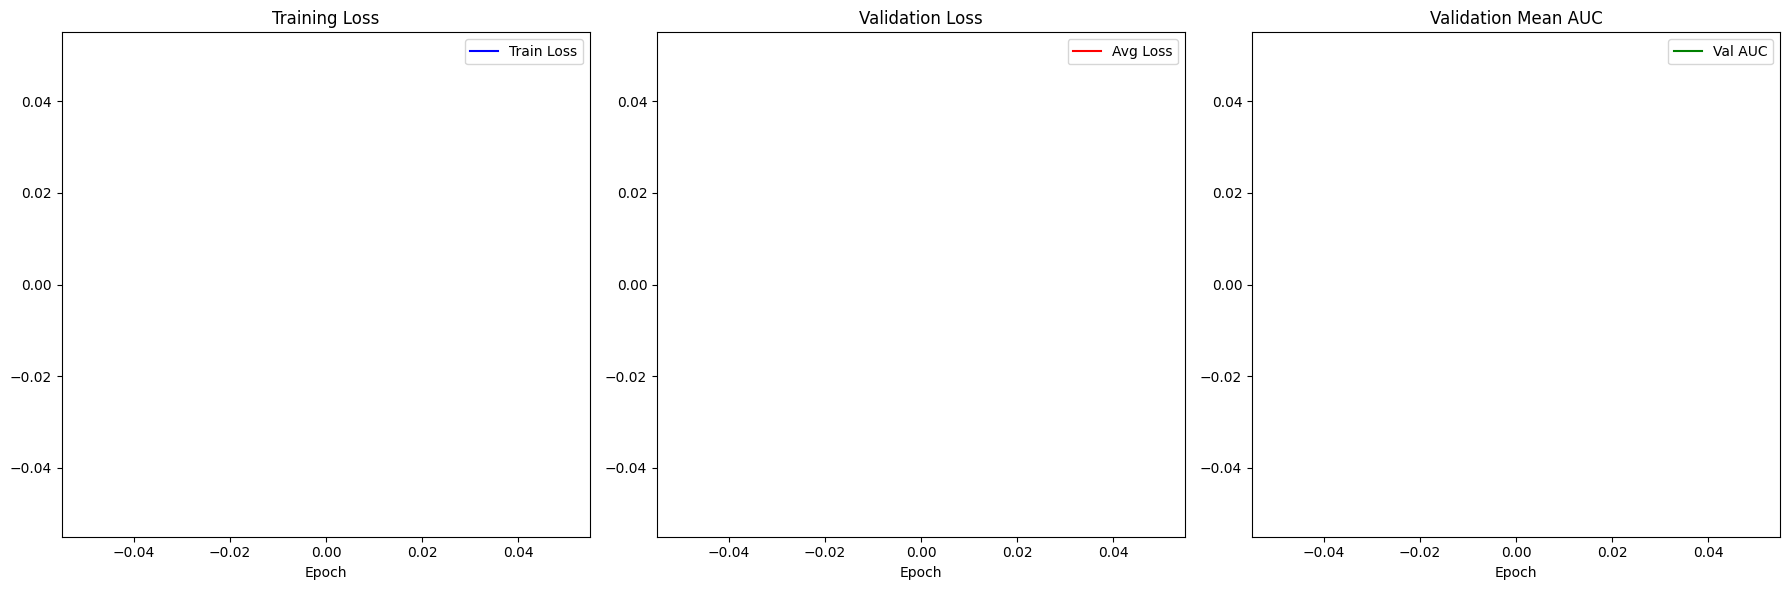

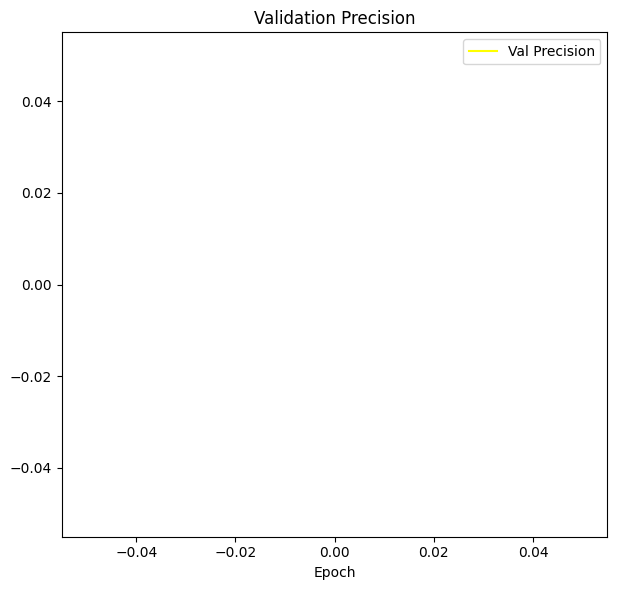

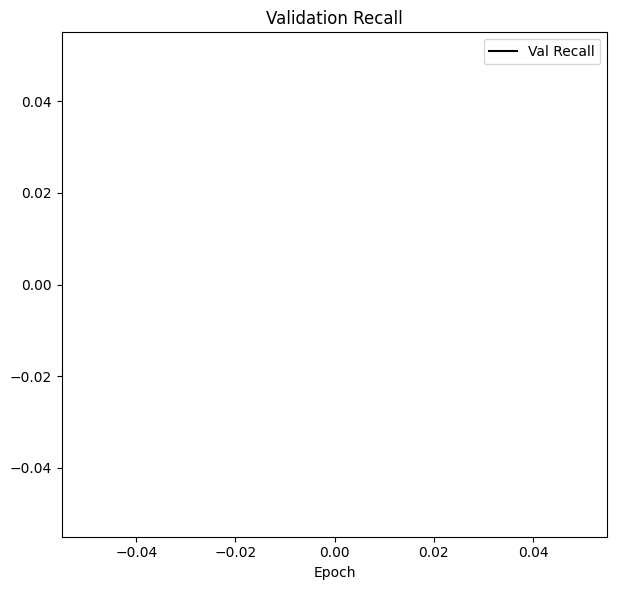

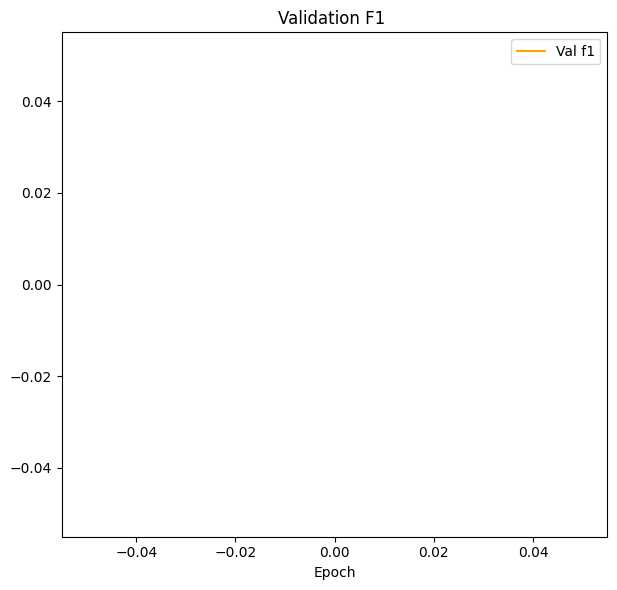

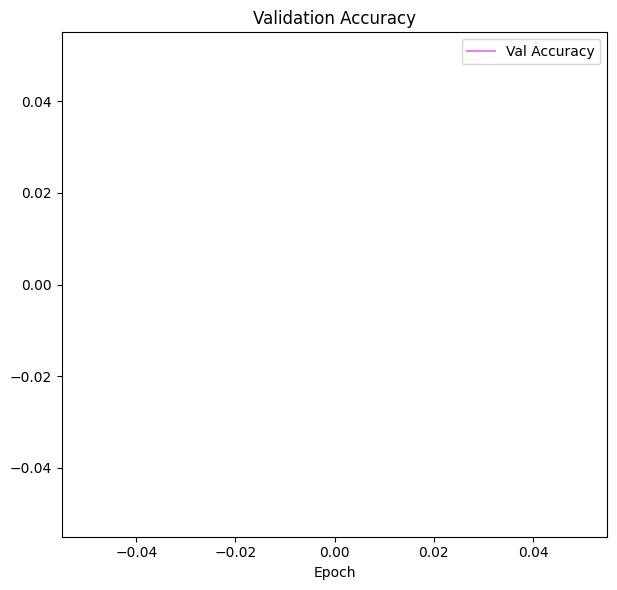

In [21]:
import matplotlib.pyplot as plt

plt.figure("train", (18, 6))

# Plot 1: Training Loss
plt.subplot(1, 3, 1)
plt.title("Training Loss")
x = [i + 1 for i in range(len(epoch_loss_values_train))]  # Assuming train_loss_values exist
y = epoch_loss_values_train
plt.xlabel("Epoch")
plt.plot(x, y, label="Train Loss", color="blue")
plt.legend()

# Plot 2: Average Loss
plt.subplot(1, 3, 2)
plt.title("Validation Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Epoch")
plt.plot(x, y, label="Avg Loss", color="red")
plt.legend()

# Plot 3: Validation Mean AUC
plt.subplot(1, 3, 3)
plt.title("Validation Mean AUC")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Epoch")
plt.plot(x, y, label="Val AUC", color="green")
plt.legend()

plt.tight_layout()
plt.show()

plt.figure("train", (18, 6))
# Plot 4: Validation Precision
plt.subplot(1, 3, 3)
plt.title("Validation Precision")
x = [eval_num * (i + 1) for i in range(len(precision_values))]
y = precision_values
plt.xlabel("Epoch")
plt.plot(x, y, label="Val Precision", color="yellow")
plt.legend()

plt.tight_layout()
plt.show()


plt.figure("train", (18, 6))
# Plot 5: Validation Recall
plt.subplot(1, 3, 3)
plt.title("Validation Recall")
x = [eval_num * (i + 1) for i in range(len(recall_values))]
y = recall_values
plt.xlabel("Epoch")
plt.plot(x, y, label="Val Recall", color="black")
plt.legend()

plt.tight_layout()
plt.show()


plt.figure("train", (18, 6))
# Plot 6: Validation F1
plt.subplot(1, 3, 3)
plt.title("Validation F1 ")
x = [eval_num * (i + 1) for i in range(len(f1_values))]
y = f1_values
plt.xlabel("Epoch")
plt.plot(x, y, label="Val f1", color="orange")
plt.legend()

plt.tight_layout()
plt.show()


plt.figure("train", (18, 6))
# Plot 7: Validation Accuracy
plt.subplot(1, 3, 3)
plt.title("Validation Accuracy")
x = [eval_num * (i + 1) for i in range(len(accuracy_values))]
y = accuracy_values
plt.xlabel("Epoch")
plt.plot(x, y, label="Val Accuracy", color="violet")
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
model.load_state_dict(torch.load('/kaggle/input/roberta-nfnet-proposed-metrics/roberta-nfnet(300).pt')["state_dict"], strict=False)
model.eval()
with torch.no_grad():
    mean_auc, mean_loss, auc, precision, recall, f1, accuracy = test(test_loader)
print(f"Mean AUC: {mean_auc:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

<ipython-input-22-8d1e97b36f28>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/roberta-nfnet-proposed-metrics/roberta-nfnet

Mean AUC: 0.9831
Mean Loss: 0.1146
Precision: 0.9118
Recall: 0.9307
F1 Score: 0.9211
Accuracy: 0.9719
